klue/roberta-small 모델 사용

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ln -s /content/drive/MyDrive/ /gdrive

In [ ]:
!mkdir data

In [ ]:
!cp /gdrive/aicon/aicon_retrailer/train/train.csv data/
!cp /gdrive/aicon/aicon_retrailer/test/test.csv data/
!cp /gdrive/aicon/aicon_retrailer/val/val.csv data/
!cp /gdrive/aicon/aicon_retrailer/sample_submission.csv data/
!cp -r /gdrive/aicon/aicon_retrailer/backup/checkpoint-44506 ./

In [ ]:
!pip install transformers datasets optuna ray[tune]

     |████████████████████████████████| 2.8 MB 7.4 MB/s 
     |████████████████████████████████| 264 kB 72.5 MB/s 
     |████████████████████████████████| 302 kB 97.9 MB/s 
     |████████████████████████████████| 49.6 MB 10 kB/s 
     |████████████████████████████████| 895 kB 78.4 MB/s 
     |████████████████████████████████| 3.3 MB 63.1 MB/s 
     |████████████████████████████████| 50 kB 131 kB/s 
     |████████████████████████████████| 636 kB 73.1 MB/s 
     |████████████████████████████████| 243 kB 75.6 MB/s 
     |████████████████████████████████| 119 kB 71.5 MB/s 
     |████████████████████████████████| 80 kB 11.4 MB/s 
     |████████████████████████████████| 208 kB 97.5 MB/s 
     |████████████████████████████████| 75 kB 5.7 MB/s 
     |████████████████████████████████| 111 kB 66.4 MB/s 
     |████████████████████████████████| 49 kB 7.9 MB/s 
     |████████████████████████████████| 141 kB 76.1 MB/s 
     |████████████████████████████████| 72 kB 705 kB/s 
     |███████████████████

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
import warnings
import re

import numpy as np
import pandas as pd

import datasets
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

#from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

import seaborn as sns

import optuna
import ray
from ray import tune

warnings.filterwarnings(action='ignore')

In [ ]:
train = pd.read_csv("./data/train.csv")
valid = pd.read_csv("./data/val.csv")
test = pd.read_csv("./data/test.csv")

In [ ]:
dataset = pd.concat([train, valid], join='inner')

In [ ]:
map_dict = {'AS_날짜_요청': 0,'AS_날짜_질문': 1,'AS_방법_요청': 2,'AS_방법_질문': 3,'AS_비용_요청': 4,'AS_비용_질문': 5,
                        'AS_시간_질문': 6,'AS_일반_질문': 7,'결제_방식_질문': 8,'결제_수단_질문': 9,'결제_시기_질문': 10,'결제_영수증_질문': 11,
                        '결제_오류_질문': 12,'결제_일반_질문': 13,'결제_일반_확인': 14,'결제_재결제_질문': 15,'결제_추가_질문': 16,
                        '결제_취소_질문': 17,'결제_할인_질문': 18,'교환|반품|환불_방법_요청': 19,'교환|반품|환불_방법_질문': 20,
                        '교환|반품|환불_방법_확인': 21,'교환|반품|환불_비용_질문': 22,'교환|반품|환불_시간_요청': 23,
                        '교환|반품|환불_시간_질문': 24,'교환|반품|환불_일반_요청': 25,'교환|반품|환불_일반_질문': 26,
                        '교환|반품|환불_일반_확인': 27,'구매_예약_요청': 28,'구매_예약_질문': 29,'구매_제품_요청': 30,'구매_제품_질문': 31,
                        '매장_이용_요청': 32,'매장_이용_질문': 33,'매장_정보_질문': 34,'멤버십_사용_질문': 35,'멤버십_적립_질문': 36,
                        '배송_날짜_요청': 37,'배송_날짜_질문': 38,'배송_날짜_확인': 39,'배송_방법_요청': 40,'배송_방법_질문': 41,
                        '배송_방법_확인': 42,'배송_비용_질문': 43,'배송_오류_질문': 44,'배송_오류_확인': 45,'배송_일반_요청': 46,
                        '배송_일반_질문': 47,'배송_일반_확인': 48,'배송_지역_요청': 49,'배송_지역_질문': 50,'배송_택배사_질문': 51,
                        '부가서비스_날짜_요청': 52,'부가서비스_날짜_질문': 53,'부가서비스_방법_요청': 54,'부가서비스_방법_질문': 55,
                        '부가서비스_비용_요청': 56,'부가서비스_비용_질문': 57,'웹사이트_사용_질문': 58,'웹사이트_오류_질문': 59,
                        '제품_가격_비교': 60,'제품_가격_요청': 61,'제품_가격_질문': 62,'제품_가격_확인': 63,'제품_구성_요청': 64,
                        '제품_구성_질문': 65,'제품_구성_확인': 66,'제품_날짜_질문': 67,'제품_방법_요청': 68,'제품_방법_질문': 69,
                        '제품_방법_확인': 70,'제품_불량_요청': 71,'제품_불량_질문': 72,'제품_불량_확인': 73,'제품_소재_질문': 74,
                        '제품_시용_요청': 75,'제품_시용_질문': 76,'제품_용도_질문': 77,'제품_용도_확인': 78,'제품_원산지_질문': 79,
                        '제품_일반_비교': 80,'제품_일반_요청': 81,'제품_일반_질문': 82,'제품_일반_확인': 83,'제품_입고_요청': 84,
                        '제품_입고_질문': 85,'제품_재고_요청': 86,'제품_재고_질문': 87,'제품_재고_확인': 88,'제품_정보_비교': 89,
                        '제품_정보_요청': 90,'제품_정보_질문': 91,'제품_정보_확인': 92,'제품_추천_비교': 93,'제품_추천_요청': 94,
                        '제품_추천_질문': 95,'제품_추천_확인': 96,'제품_커스텀_요청': 97,'제품_커스텀_질문': 98,'제품_품질_비교': 99,
                        '제품_품질_요청': 100,'제품_품질_질문': 101,'제품_품질_확인': 102,'제품_호환_질문': 103,'제품_호환_확인': 104,
                        '포장_방식_요청': 105,'포장_방식_질문': 106,'포장_비용_질문': 107,'포장_일반_질문': 108,'행사_기간_질문': 109,
                        '행사_기간_확인': 110,'행사_날짜_질문': 111,'행사_유형_질문': 112,'행사_유형_확인': 113,'행사_일반_질문': 114,
                        '행사_일반_확인': 115,'행사_정보_요청': 116,'행사_정보_질문': 117}

In [ ]:
def set_values(row, value):
    return value[row]

In [ ]:
dataset['label'] = dataset['intent'].apply(set_values, args =(map_dict, ))

In [ ]:
dataset.head()

,conv_num,intent,question,answer,label
0,5087,AS_날짜_요청,제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.,"네, 무상 리퍼 남았는지 확인 도와드리겠습니다.",0
1,9373,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?,"네, 휴대폰 내일 받으실 수 있습니다.",0
2,9374,AS_날짜_요청,오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?,"네, 이번주 안으로 받으실 수 있습니다.",0
3,9378,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?,"죄송합니다만, 내일 받아보시는건 어렵습니다.",0
4,9379,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?,"아니요, 내일은 어렵습니다.",0


In [ ]:
dataset['intent'].fillna('NAN', inplace=True)
dataset['question'].fillna('NAN', inplace=True)
dataset['answer'].fillna('NAN', inplace=True)

In [ ]:
dataset['data'] = dataset['question'] + dataset['answer']
test['data'] = test['question'] + test['answer']

In [ ]:
dataset.head()

,conv_num,intent,question,answer,label,data
0,5087,AS_날짜_요청,제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.,"네, 무상 리퍼 남았는지 확인 도와드리겠습니다.",0,"제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.네, 무상 리퍼 남았는지 확인..."
1,9373,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?,"네, 휴대폰 내일 받으실 수 있습니다.",0,"오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?네, 휴대폰 내일 받으실 수 있습니다."
2,9374,AS_날짜_요청,오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?,"네, 이번주 안으로 받으실 수 있습니다.",0,"오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?네, 이번주 안으로 받으실..."
3,9378,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?,"죄송합니다만, 내일 받아보시는건 어렵습니다.",0,"오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?죄송합니다만, 내일 받아보시는건 어..."
4,9379,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?,"아니요, 내일은 어렵습니다.",0,"오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?아니요, 내일은 어렵습니다."


In [ ]:
test.head()

,conv_num,question,answer,data
0,9710,노트북 수리 맡기면 바로 받을 수 있나요?,오늘 바로 받으실 수 있어요.,노트북 수리 맡기면 바로 받을 수 있나요?오늘 바로 받으실 수 있어요.
1,9711,노트북 수리 맡기면 오늘 받을 수 있어요?,"네, 오늘 받으실 수 있습니다.","노트북 수리 맡기면 오늘 받을 수 있어요?네, 오늘 받으실 수 있습니다."
2,9728,오늘 노트북 수리 들어가면 내일 찾을 수 있죠?,"네, 내일 찾아가세요.","오늘 노트북 수리 들어가면 내일 찾을 수 있죠?네, 내일 찾아가세요."
3,9737,어제 수리맡긴 노트북 내일 찾을 수 있습니까?,"네, 내일 찾으러 오시면 됩니다.","어제 수리맡긴 노트북 내일 찾을 수 있습니까?네, 내일 찾으러 오시면 됩니다."
4,11050,TV AS 이번주 안에 가능한가요?,"네, 이번주까지 해드리겠습니다.","TV AS 이번주 안에 가능한가요?네, 이번주까지 해드리겠습니다."


In [ ]:
dataset=dataset[['data','label']]
test=test[['data']]

In [ ]:
dataset.head()

,data,label
0,"제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.네, 무상 리퍼 남았는지 확인...",0
1,"오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?네, 휴대폰 내일 받으실 수 있습니다.",0
2,"오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?네, 이번주 안으로 받으실...",0
3,"오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?죄송합니다만, 내일 받아보시는건 어...",0
4,"오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?아니요, 내일은 어렵습니다.",0


In [ ]:
test.head()

,data
0,노트북 수리 맡기면 바로 받을 수 있나요?오늘 바로 받으실 수 있어요.
1,"노트북 수리 맡기면 오늘 받을 수 있어요?네, 오늘 받으실 수 있습니다."
2,"오늘 노트북 수리 들어가면 내일 찾을 수 있죠?네, 내일 찾아가세요."
3,"어제 수리맡긴 노트북 내일 찾을 수 있습니까?네, 내일 찾으러 오시면 됩니다."
4,"TV AS 이번주 안에 가능한가요?네, 이번주까지 해드리겠습니다."


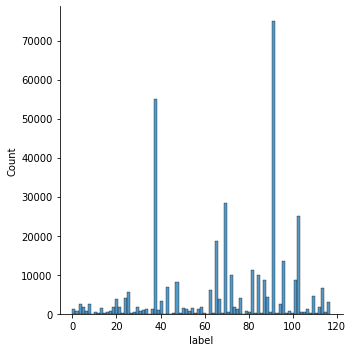

In [ ]:
sns.displot(dataset.label)

In [ ]:
model_checkpoint = "checkpoint-44506"
RANDOM_SEED = 42

In [ ]:
target = dataset['label']
dataset_train, dataset_val = train_test_split(dataset,test_size = 0.03, stratify = target, random_state = RANDOM_SEED)

In [ ]:
dataset_train.count()

data     363539
label    363539
dtype: int64

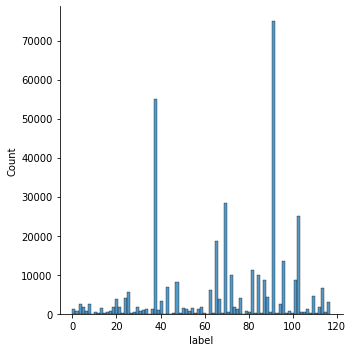

In [ ]:
sns.displot(dataset.label)

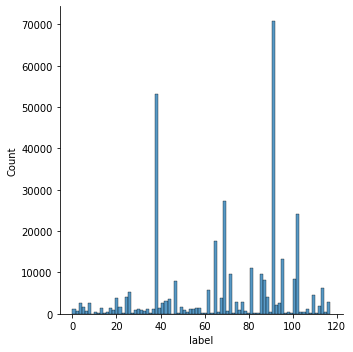

In [ ]:
sns.displot(dataset_train.label)

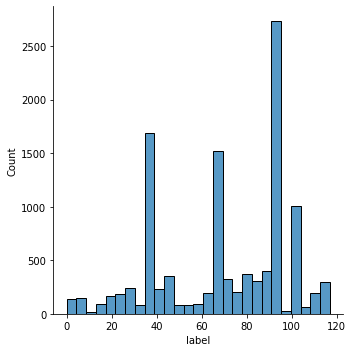

In [ ]:
sns.displot(dataset_val.label)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
def tokenized_dataset(dataset, tokenizer):
  tokenized_sentences = tokenizer(
      list(dataset['data']),
      return_tensors="pt",
      padding=True,
      truncation=True
      )
  return tokenized_sentences

In [ ]:
# Dataset 구성.
class ROBERTA_Dataset(Dataset):
    def __init__(self, tokenized_dataset, labels):
        self.tokenized_dataset = tokenized_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.tokenized_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
    def get_classes(self):
        return self.labels

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')

In [ ]:
submission.head()

,conv_num,intent
0,9710,카테고리_채우기
1,9711,카테고리_채우기
2,9728,카테고리_채우기
3,9737,카테고리_채우기
4,11050,카테고리_채우기


In [ ]:
submission['label'] = submission['intent']

In [ ]:
submission.head()

,conv_num,intent,label
0,9710,카테고리_채우기,카테고리_채우기
1,9711,카테고리_채우기,카테고리_채우기
2,9728,카테고리_채우기,카테고리_채우기
3,9737,카테고리_채우기,카테고리_채우기
4,11050,카테고리_채우기,카테고리_채우기


In [ ]:
submission.loc[submission.label == '카테고리_채우기', 'label'] = 0

In [ ]:
submission.head()

,conv_num,intent,label
0,9710,카테고리_채우기,0
1,9711,카테고리_채우기,0
2,9728,카테고리_채우기,0
3,9737,카테고리_채우기,0
4,11050,카테고리_채우기,0


In [ ]:
train_label=dataset_train['label'].values
val_label=dataset_val['label'].values
test_label=submission['label'].values

tokenized_train = tokenized_dataset(dataset_train, tokenizer)
tokenized_val = tokenized_dataset(dataset_val, tokenizer)
tokenized_test = tokenized_dataset(test, tokenizer)

data_train = ROBERTA_Dataset(tokenized_train, train_label)
data_val = ROBERTA_Dataset(tokenized_val, val_label)
data_test = ROBERTA_Dataset(tokenized_test, test_label)

In [ ]:
import gc
gc.collect()

50

In [ ]:
num_labels = 118
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [ ]:
metric = load_metric("glue", "qnli")

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [ ]:
metric_name = "accuracy"

args = TrainingArguments(
    "/gdrive/aicon/aicon_retrailer/backup",
    evaluation_strategy="steps",
    save_steps = 20000,
    eval_steps = 20000, 
    logging_steps = 20000, 
    learning_rate=2e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.0125,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    greater_is_better=True,
    seed = 42
)

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=data_train,
    eval_dataset=data_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

loading configuration file checkpoint-44506/config.json
Model config RobertaConfig {
  "_name_or_path": "checkpoint-rolarge-epoch1",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "

In [ ]:
trainer.train("checkpoint-44506")

loading configuration file checkpoint-44506/config.json
Model config RobertaConfig {
  "_name_or_path": "checkpoint-rolarge-epoch1",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "

  0%|          | 0/44506 [00:00<?, ?it/s]

Didn't find an RNG file, if you are resuming a training that was launched in a distributed fashion, reproducibility is not guaranteed.


Step,Training Loss,Validation Loss,Accuracy
60000,0.983600,1.046302,0.691035
80000,0.968700,1.013461,0.695838


***** Running Evaluation *****
  Num examples = 11244
  Batch size = 8
Saving model checkpoint to /gdrive/aicon/aicon_retrailer/backup/checkpoint-60000
Configuration saved in /gdrive/aicon/aicon_retrailer/backup/checkpoint-60000/config.json
Model weights saved in /gdrive/aicon/aicon_retrailer/backup/checkpoint-60000/pytorch_model.bin
tokenizer config file saved in /gdrive/aicon/aicon_retrailer/backup/checkpoint-60000/tokenizer_config.json
Special tokens file saved in /gdrive/aicon/aicon_retrailer/backup/checkpoint-60000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 11244
  Batch size = 8
Saving model checkpoint to /gdrive/aicon/aicon_retrailer/backup/checkpoint-80000
Configuration saved in /gdrive/aicon/aicon_retrailer/backup/checkpoint-80000/config.json
Model weights saved in /gdrive/aicon/aicon_retrailer/backup/checkpoint-80000/pytorch_model.bin
tokenizer config file saved in /gdrive/aicon/aicon_retrailer/backup/checkpoint-80000/tokenizer_config.json
Special

TrainOutput(global_step=90886, training_loss=0.49288161087447463, metrics={'train_runtime': 67026.8742, 'train_samples_per_second': 10.848, 'train_steps_per_second': 1.356, 'total_flos': 3.4024496517777786e+17, 'train_loss': 0.49288161087447463, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 11244
  Batch size = 8


{'epoch': 2.0,
 'eval_accuracy': 0.6986837424404126,
 'eval_loss': 1.011231541633606,
 'eval_runtime': 350.9672,
 'eval_samples_per_second': 32.037,
 'eval_steps_per_second': 4.006}

In [ ]:
pred = trainer.predict(data_test)
pred = pred[0]
pred

***** Running Prediction *****
  Num examples = 40730
  Batch size = 8


array([[10.111411  ,  7.779877  ,  4.216143  , ...,  1.7851856 ,
         1.5711124 , -0.36824426],
       [10.163979  ,  6.938902  ,  4.82848   , ...,  2.1631896 ,
         1.9893622 , -0.21143888],
       [10.1132965 ,  6.5339546 ,  4.9825478 , ...,  2.1972914 ,
         2.1068997 , -0.11309154],
       ...,
       [-1.7208787 , -1.2374376 , -0.50819635, ...,  0.14642784,
         6.1076703 , 10.822112  ],
       [-2.0536242 , -1.683908  , -0.61888343, ...,  0.28317013,
         5.668411  , 10.539889  ],
       [-1.2108831 , -0.8860632 , -0.9850215 , ...,  0.6645155 ,
         3.8308465 ,  8.104063  ]], dtype=float32)

In [ ]:
np.save("/gdrive/aicon/aicon_retrailer/npy/pred_roberta_large_whole_0.npy", pred)

In [ ]:
pred = np.argmax(pred,1)
submission['label'] = pred

In [ ]:
dict_map = {v : k for k, v in map_dict.items()}

dict_map

{0: 'AS_날짜_요청',
 1: 'AS_날짜_질문',
 2: 'AS_방법_요청',
 3: 'AS_방법_질문',
 4: 'AS_비용_요청',
 5: 'AS_비용_질문',
 6: 'AS_시간_질문',
 7: 'AS_일반_질문',
 8: '결제_방식_질문',
 9: '결제_수단_질문',
 10: '결제_시기_질문',
 11: '결제_영수증_질문',
 12: '결제_오류_질문',
 13: '결제_일반_질문',
 14: '결제_일반_확인',
 15: '결제_재결제_질문',
 16: '결제_추가_질문',
 17: '결제_취소_질문',
 18: '결제_할인_질문',
 19: '교환|반품|환불_방법_요청',
 20: '교환|반품|환불_방법_질문',
 21: '교환|반품|환불_방법_확인',
 22: '교환|반품|환불_비용_질문',
 23: '교환|반품|환불_시간_요청',
 24: '교환|반품|환불_시간_질문',
 25: '교환|반품|환불_일반_요청',
 26: '교환|반품|환불_일반_질문',
 27: '교환|반품|환불_일반_확인',
 28: '구매_예약_요청',
 29: '구매_예약_질문',
 30: '구매_제품_요청',
 31: '구매_제품_질문',
 32: '매장_이용_요청',
 33: '매장_이용_질문',
 34: '매장_정보_질문',
 35: '멤버십_사용_질문',
 36: '멤버십_적립_질문',
 37: '배송_날짜_요청',
 38: '배송_날짜_질문',
 39: '배송_날짜_확인',
 40: '배송_방법_요청',
 41: '배송_방법_질문',
 42: '배송_방법_확인',
 43: '배송_비용_질문',
 44: '배송_오류_질문',
 45: '배송_오류_확인',
 46: '배송_일반_요청',
 47: '배송_일반_질문',
 48: '배송_일반_확인',
 49: '배송_지역_요청',
 50: '배송_지역_질문',
 51: '배송_택배사_질문',
 52: '부가서비스_날짜_요청',
 53: '부가서비스_날짜_질문',
 54: '부가서비스_방법_요청',
 55: '부

In [ ]:
submission['intent'] = submission['label'].apply(set_values, args =(dict_map, ))
submission =submission.drop('label', axis=1)
submission.head()

,conv_num,intent
0,9710,AS_날짜_요청
1,9711,AS_날짜_요청
2,9728,AS_날짜_요청
3,9737,AS_날짜_요청
4,11050,AS_날짜_요청


In [ ]:
submission.to_csv("/gdrive/aicon/aicon_retrailer/result/klue_roberta_large_whole_0.csv",index=False)

참고문헌  
transformers 공식문서 How to fine-tune a model on text classification
https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb  

